# Multi-task learning on RSSI based location estimation

In [54]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

from torch.utils.data import DataLoader
# from mlpdataset import RSSIDataset
# from model import MLP
from torch.utils.data import Dataset
# from early_stoping import EarlyStopping
# from tdqm import tdqm, trange

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['simhei']
plt.rcParams['axes.unicode_minus'] = False

## Data precoss

### Load augmented data coped by baseline.ipynb

In [55]:
train_df = pd.read_csv('./train_aug.csv')
test_df = pd.read_csv('./ver_aug.csv')

In [56]:
train_df.drop(columns=['UnixTime'], inplace=True)
test_df.drop(columns=['UnixTime'], inplace=True)

In [57]:
train_df.head()

,Latitude,Longitude,SSID_1,RSSI(dBm)_1,Obstacle_1,latitude_1,longitude_1,SSID_2,RSSI(dBm)_2,Obstacle_2,latitude_2,longitude_2,SSID_3,RSSI(dBm)_3,Obstacle_3,latitude_3,longitude_3
0,35.158622,136.924466,1,-66,0,35.158613,136.924697,2,-62,0,35.158638,136.924374,3,-63,0,35.158979,136.924477
1,35.158622,136.924466,1,-66,0,35.158613,136.924697,3,-63,0,35.158979,136.924477,2,-62,0,35.158638,136.924374
2,35.158622,136.924466,2,-62,0,35.158638,136.924374,1,-66,0,35.158613,136.924697,3,-63,0,35.158979,136.924477
3,35.158622,136.924466,2,-62,0,35.158638,136.924374,3,-63,0,35.158979,136.924477,1,-66,0,35.158613,136.924697
4,35.158622,136.924466,3,-63,0,35.158979,136.924477,1,-66,0,35.158613,136.924697,2,-62,0,35.158638,136.924374


In [58]:
test_df.head()

,Latitude,Longitude,SSID_1,RSSI(dBm)_1,Obstacle_1,latitude_1,longitude_1,SSID_2,RSSI(dBm)_2,Obstacle_2,latitude_2,longitude_2,SSID_3,RSSI(dBm)_3,Obstacle_3,latitude_3,longitude_3
0,35.158649,136.924393,1,-75,0,35.158613,136.924697,2,-63,0,35.158638,136.924374,3,-72,0,35.158979,136.924477
1,35.158649,136.924393,1,-75,0,35.158613,136.924697,3,-72,0,35.158979,136.924477,2,-63,0,35.158638,136.924374
2,35.158649,136.924393,2,-63,0,35.158638,136.924374,1,-75,0,35.158613,136.924697,3,-72,0,35.158979,136.924477
3,35.158649,136.924393,2,-63,0,35.158638,136.924374,3,-72,0,35.158979,136.924477,1,-75,0,35.158613,136.924697
4,35.158649,136.924393,3,-72,0,35.158979,136.924477,1,-75,0,35.158613,136.924697,2,-63,0,35.158638,136.924374


In [59]:
x_ol, y_ol = train_df['Latitude'].values, train_df['Longitude'].values
x_tol, y_tol = test_df['Latitude'].values.copy(), test_df['Longitude'].values.copy()

In [60]:
x_tol

array([35.15864898, 35.15864898, 35.15864898, ..., 35.15859294,
       35.15859294, 35.15859294])

In [61]:
train_df.columns

Index(['Latitude', 'Longitude', 'SSID_1', 'RSSI(dBm)_1', 'Obstacle_1',
       'latitude_1', 'longitude_1', 'SSID_2', 'RSSI(dBm)_2', 'Obstacle_2',
       'latitude_2', 'longitude_2', 'SSID_3', 'RSSI(dBm)_3', 'Obstacle_3',
       'latitude_3', 'longitude_3'],
      dtype='object')

### Standarization

In [62]:
xscaler = StandardScaler()
tposx = ['Latitude']
posx1 = ['latitude_1']
posx2 = ['latitude_2']
posx3 = ['latitude_3']

yscaler = StandardScaler()
tposy = ['Longitude']
posy1 = ['longitude_1']
posy2 = ['longitude_2']
posy3 = ['longitude_3']

In [63]:
train_df[tposx] = xscaler.fit_transform(train_df[tposx])
train_df[posx1] = xscaler.transform(train_df[posx1])
train_df[posx2] = xscaler.transform(train_df[posx2])
train_df[posx3] = xscaler.transform(train_df[posx3])

test_df[tposx] = xscaler.transform(test_df[tposx])
test_df[posx1] = xscaler.transform(test_df[posx1])
test_df[posx2] = xscaler.transform(test_df[posx2])
test_df[posx3] = xscaler.transform(test_df[posx3])

train_df[tposy] = yscaler.fit_transform(train_df[tposy])
train_df[posy1] = yscaler.transform(train_df[posy1])
train_df[posy2] = yscaler.transform(train_df[posy2])
train_df[posy3] = yscaler.transform(train_df[posy3])

test_df[tposy] = yscaler.transform(test_df[tposy])
test_df[posy1] = yscaler.transform(test_df[posy1])
test_df[posy2] = yscaler.transform(test_df[posy2])
test_df[posy3] = yscaler.transform(test_df[posy3])

In [64]:
train_df.head()
test_df.head()

,Latitude,Longitude,SSID_1,RSSI(dBm)_1,Obstacle_1,latitude_1,longitude_1,SSID_2,RSSI(dBm)_2,Obstacle_2,latitude_2,longitude_2,SSID_3,RSSI(dBm)_3,Obstacle_3,latitude_3,longitude_3
0,-1.090943,-0.777915,1,-66,0,-1.147956,1.186707,2,-62,0,-0.979884,-1.555950,3,-63,0,1.263718,-0.678537
1,-1.090943,-0.777915,1,-66,0,-1.147956,1.186707,3,-63,0,1.263718,-0.678537,2,-62,0,-0.979884,-1.555950
2,-1.090943,-0.777915,2,-62,0,-0.979884,-1.555950,1,-66,0,-1.147956,1.186707,3,-63,0,1.263718,-0.678537
3,-1.090943,-0.777915,2,-62,0,-0.979884,-1.555950,3,-63,0,1.263718,-0.678537,1,-66,0,-1.147956,1.186707
4,-1.090943,-0.777915,3,-63,0,1.263718,-0.678537,1,-66,0,-1.147956,1.186707,2,-62,0,-0.979884,-1.555950


,Latitude,Longitude,SSID_1,RSSI(dBm)_1,Obstacle_1,latitude_1,longitude_1,SSID_2,RSSI(dBm)_2,Obstacle_2,latitude_2,longitude_2,SSID_3,RSSI(dBm)_3,Obstacle_3,latitude_3,longitude_3
0,-0.91015,-1.395416,1,-75,0,-1.147956,1.186707,2,-63,0,-0.979884,-1.555950,3,-72,0,1.263718,-0.678537
1,-0.91015,-1.395416,1,-75,0,-1.147956,1.186707,3,-72,0,1.263718,-0.678537,2,-63,0,-0.979884,-1.555950
2,-0.91015,-1.395416,2,-63,0,-0.979884,-1.555950,1,-75,0,-1.147956,1.186707,3,-72,0,1.263718,-0.678537
3,-0.91015,-1.395416,2,-63,0,-0.979884,-1.555950,3,-72,0,1.263718,-0.678537,1,-75,0,-1.147956,1.186707
4,-0.91015,-1.395416,3,-72,0,1.263718,-0.678537,1,-75,0,-1.147956,1.186707,2,-63,0,-0.979884,-1.555950


In [65]:
x_label = train_df['Latitude'].values

In [66]:
y_label = train_df['Longitude'].values

In [67]:
data = train_df.iloc[:, 2:].values
data
test_data = test_df.iloc[:,2:].values
test_data

array([[  1.        , -66.        ,   0.        , ...,   0.        ,
          1.26371811,  -0.67853734],
       [  1.        , -66.        ,   0.        , ...,   0.        ,
         -0.97988377,  -1.55594968],
       [  2.        , -62.        ,   0.        , ...,   0.        ,
          1.26371811,  -0.67853734],
       ...,
       [  3.        , -72.        ,   0.        , ...,   0.        ,
         -0.97988377,  -1.55594968],
       [  2.        , -61.        ,   0.        , ...,   0.        ,
          1.26371811,  -0.67853734],
       [  3.        , -72.        ,   0.        , ...,   0.        ,
          1.26371811,  -0.67853734]])

array([[  1.        , -75.        ,   0.        , ...,   0.        ,
          1.26371811,  -0.67853734],
       [  1.        , -75.        ,   0.        , ...,   0.        ,
         -0.97988377,  -1.55594968],
       [  2.        , -63.        ,   0.        , ...,   0.        ,
          1.26371811,  -0.67853734],
       ...,
       [  1.        , -61.        ,   0.        , ...,   0.        ,
         -0.97988377,  -1.55594968],
       [  2.        , -68.        ,   0.        , ...,   0.        ,
         -0.97988377,  -1.55594968],
       [  2.        , -68.        ,   0.        , ...,   0.        ,
         -1.14795617,   1.18670709]])

In [68]:
data.shape

(1536, 15)

### Construct dataset

In [69]:
class RSSIDataset(Dataset):
    # def __new__(cls, data, x_label, y_label):
    #     # if not hasattr(cls, '_instance'):
    #     #     cls._instance = super(RSSIDataset, cls).__new__(cls)
    #     return super().__new__(cls)
    def __init__(self, data, x_label, y_label):
        # self.super(Dataset)
        # super().__init__()
        self.data = data
        self.x_label = x_label
        self.y_label = y_label
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        sample = torch.from_numpy(self.data[idx])
        # x_label = torch.from_numpy(self.x_label[idx])
        x_label = torch.tensor(self.x_label[idx])
        y_label = torch.tensor(self.y_label[idx])
        # y_label = torch.from_numpy(self.y_label[idx])
        # return sample.float(), x_label.squeeze_(-1).float(), y_label.squeeze_(-1).float()
        return sample.float(), x_label.unsqueeze_(-1).float(), y_label.unsqueeze_(-1).float()

In [70]:
dataset = RSSIDataset(data, x_label, y_label)
tdataset = RSSIDataset(test_data, x_tol, y_tol)

In [71]:
dataset[10]

(tensor([  3.0000, -63.0000,   0.0000,   1.2637,  -0.6785,   1.0000, -66.0000,
           0.0000,  -1.1480,   1.1867,   2.0000, -62.0000,   0.0000,  -0.9799,
          -1.5559]),
 tensor([-1.0909]),
 tensor([-0.7779]))

## Train

### multi-task model

In [72]:
class MLP(nn.Module):
    def __init__(self, num_neuron = [15, 10, 5, 1], num_shared_layer = 1, deep_tower = 1):
        super().__init__()
        self.num_neuron = num_neuron
        self.num_shared_layer = num_shared_layer
        self.deep_tower = deep_tower
        self.sl = nn.ModuleList([self.fc_layer(num_neuron[0:2])])
        for i in range(1, num_shared_layer):
            self.sl.append(self.fc_layer(num_neuron[i:i+2]))
        self.towerx = nn.ModuleList([self.fc_layer(num_neuron[num_shared_layer:num_shared_layer+2])])
        self.towery = nn.ModuleList([self.fc_layer(num_neuron[num_shared_layer:num_shared_layer+2])])
        for i in range(1, deep_tower):
            self.towerx.append(self.fc_layer(num_neuron[num_shared_layer+i:num_shared_layer+2+i]))
            self.towery.append(self.fc_layer(num_neuron[num_shared_layer+i:num_shared_layer+2+i]))
        # self.towerx = self.fc_layer(num_neuron[-3:-1])
        # self.towery = self.fc_layer(num_neuron[-3:-1])
        self.predx = nn.Linear(num_neuron[-2], num_neuron[-1])
        self.predy = nn.Linear(num_neuron[-2], num_neuron[-1])
            
        
    def forward(self, x):
        for i in range(0, self.num_shared_layer):
            x = self.sl[i](x)
        tx = self.towerx[0](x)
        ty = self.towery[0](x)
        for i in range(1, self.deep_tower):
            tx = self.towerx[i](tx)
            ty = self.towery[i](ty)
        return self.predx(tx), self.predy(ty)
        # return self.predx(x), self.predy(x)
            
    def fc_layer(self, para):
        fc_block = nn.Sequential(
            nn.Linear(para[0], para[1]),
            # nn.ReLU()
            nn.Tanh()
        )
        return fc_block

### Load best model and prediction

In [73]:
train_loader = DataLoader(dataset=dataset, shuffle=True, batch_size = 16)

In [74]:
# from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
    
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = np.radians(lon1)
    lon2 = np.radians(lon2)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
 
    c = 2 * np.arcsin(np.sqrt(np.abs(a)))
        
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6378137
      
    # calculate the result
    return (c * r)

In [80]:
mlp = MLP()
mlp.load_state_dict(torch.load("39.pt"))
x_pred, y_pred = mlp(torch.from_numpy(tdataset.data[:]).float())
x_pred = xscaler.inverse_transform(x_pred.detach().numpy())
y_pred = yscaler.inverse_transform(y_pred.detach().numpy())
d = distance(x_pred.squeeze(), x_tol, y_pred.squeeze(), y_tol)

<All keys matched successfully>

In [81]:
x_tol

array([35.15864898, 35.15864898, 35.15864898, ..., 35.15859294,
       35.15859294, 35.15859294])

In [82]:
d

array([4.20029037, 2.45040685, 5.48041662, ..., 2.05865203, 2.05865203,
       2.05865203])

In [83]:
d.mean()

7.568669106266748

In [84]:
d.max()

25.119281868934795

In [85]:
d.shape

(1542,)

In [86]:
import matplotlib.pyplot as plt

(array([157., 116., 130.,  22.,  40., 185., 137., 104., 151.,  30.,  78.,
         46.,  27.,  60.,  58.,  28.,  20.,  33.,  18.,   0.,   0.,   1.,
          0.,   0.,   0.,  21.,  20.,   1.,  39.,  20.]),
 array([ 0.74189455,  1.55447412,  2.3670537 ,  3.17963328,  3.99221286,
         4.80479243,  5.61737201,  6.42995159,  7.24253117,  8.05511074,
         8.86769032,  9.6802699 , 10.49284947, 11.30542905, 12.11800863,
        12.93058821, 13.74316778, 14.55574736, 15.36832694, 16.18090652,
        16.99348609, 17.80606567, 18.61864525, 19.43122483, 20.2438044 ,
        21.05638398, 21.86896356, 22.68154314, 23.49412271, 24.30670229,
        25.11928187]),
 <BarContainer object of 30 artists>)

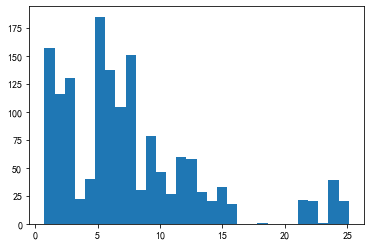

In [92]:
plt.hist(d, bins=30)
plt.savefig('res.jpg', dpi=300)

## Summary

In [46]:
print(40*'-' + 'results' + 40*'-')
print("mean error: {:.8f} with std {:.8f}".format(err_mean.mean(), err_mean.std()))
print("maximum error: {:.8f} with std {:.8f}".format(err_max.mean(), err_max.std()))

----------------------------------------results----------------------------------------
mean error: 9.66662213 with std 0.90924379
maximum error: 34.51337252 with std 8.18946170


In [48]:
err_mean.min()

7.568669106266748

In [52]:
np.argmin(err_mean)

39

In [54]:
err_mean[39]
err_max[39]

7.568669106266748

25.119281868934795

In [55]:
np.savez('res.npz', err_mean=err_mean, err_max=err_max)